In [31]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score

In [2]:
# Loading the Iris dataset

iris = load_iris()
X = iris.data[:, 2:] # Selecting the two last columns
y = iris.target

target_names = iris.target_names
features_names = iris.feature_names

In [3]:
# Restrict ourselves to two classes

X = X[np.logical_or(y == 1, y == 2)]
y = y[np.logical_or(y == 1, y == 2)]

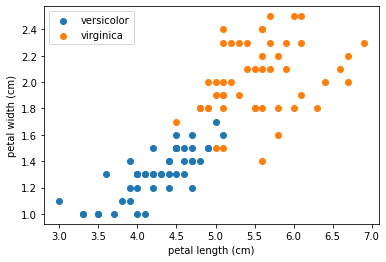

In [4]:
# Plotting

plt.scatter(X[y == 1][:,0], X[y == 1][:,1], label=target_names[1])
plt.scatter(X[y == 2][:,0], X[y == 2][:,1], label=target_names[2])
plt.xlabel(features_names[2])
plt.ylabel(features_names[3])
plt.legend()
plt.show()

In [42]:
def gini(partition):
    """
    Measure of the purity of a sample.
    """
    partition_sum = partition.sum()
    g = 1 - ((partition/partition_sum)**2).sum()
    return g

In [46]:
# Loop through features and feature values, calculate information gain and find the best separation boundary

gini_old = gini(y)
information_gain_array = np.zeros(X.shape)

for j in range(X.shape[1]):
    for i in range(X.shape[0]):
        thr = X[i,j]

        true_branch = X[X[:,j] >= thr]
        false_branch = X[X[:,j] < thr]

        true_branch_labels = y[X[:,j] >= thr]
        false_branch_labels = y[X[:,j] < thr]

        _, partition_true = np.unique(true_branch_labels, return_counts=True)
        _, partition_false = np.unique(false_branch_labels, return_counts=True)
        
        gini_true = gini(partition_true)
        partition_true_sum = partition_true.sum() 

        gini_false = gini(partition_false)
        partition_false_sum = partition_false.sum()

        partition_total = partition_true_sum + partition_false_sum

        weighted_mean_gini = (gini_true*partition_true_sum + gini_false*partition_false_sum)/partition_total
        information_gain = gini_old - weighted_mean_gini
        information_gain_array[i,j] = information_gain
        
flat_index = information_gain_array.argmax()
max_gain_index = np.unravel_index(flat_index, information_gain_array.shape)

In [47]:
# The prediction is

y_pred = np.zeros(X.shape[0])

y_pred[X[:,1] >= X[27,1]] = 2
y_pred[X[:,1] < X[27,1]] = 1

y_pred

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 2., 1., 1., 1., 1., 1., 1., 2., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 1., 2., 2., 2., 1., 1.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.])

In [48]:
# Measuring accuracy for our implementation

accuracy_score(y, y_pred)

0.94

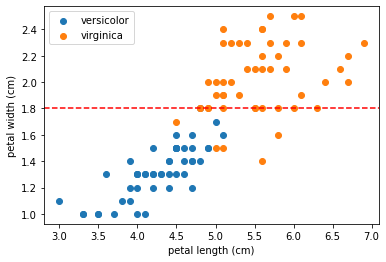

In [49]:
# Plotting decision boundary

plt.scatter(X[y == 1][:,0], X[y == 1][:,1], label=target_names[1])
plt.scatter(X[y == 2][:,0], X[y == 2][:,1], label=target_names[2])
plt.axhline(y=X[max_gain_index], c='r', ls='--')
plt.xlabel(features_names[2])
plt.ylabel(features_names[3])
plt.legend()
plt.show()

In [50]:
from sklearn.tree import DecisionTreeClassifier

tree_clf = DecisionTreeClassifier(max_depth=1, random_state=42)
tree_clf.fit(X,y)
y_pred_sklearn = tree_clf.predict(X)
y_pred_sklearn

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [51]:
# Some predictions are different

y_pred == y_pred_sklearn

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [52]:
# Comparing accuracy with sklearn. We have the same result

accuracy_score(y, y_pred_sklearn)

0.94

In [ ]:
def best_split(X, y):
    gini_old = gini(y)                                # Saving our gini before separation           
    information_gain_array = np.zeros(X.shape)        # Array for storing information gain

    for j in range(X.shape[1]):                       # Loop through all rows  
        for i in range(X.shape[0]):                   # Loop through all columns
            thr = X[i,j]                              # Thrshold value to be considered as split value
            
            # True branch contains all values greater or equal than thr, otherwise, it goes to false branch
            true_branch = X[X[:,j] >= thr]
            false_branch = X[X[:,j] < thr]

            # Get the labels for the branches
            true_branch_labels = y[X[:,j] >= thr]     
            false_branch_labels = y[X[:,j] < thr]
            
            # Counting labels in branches
            _, partition_true = np.unique(true_branch_labels, return_counts=True)   
            _, partition_false = np.unique(false_branch_labels, return_counts=True)
        
            # Calculate gini on the partitions
            gini_true = gini(partition_true)            
            gini_false = gini(partition_false)
            
            # Calculate the number of samples in the partitions 
            partition_true_sum = partition_true.sum()
            partition_false_sum = partition_false.sum()
            partition_total = partition_true_sum + partition_false_sum  # Total number of samples (len(y))
            
            # Getting the mean gini using the size of the partition as weight
            weighted_mean_gini = (gini_true*partition_true_sum + gini_false*partition_false_sum)/partition_total
            
            # The difference from the old to the new gini is the information gain
            information_gain = gini_old - weighted_mean_gini
            information_gain_array[i,j] = information_gain
            
    # Find the best information gain
    flat_index = information_gain_array.argmax()    
    max_gain_index = np.unravel_index(flat_index, information_gain_array.shape)
    
    
    return max_gain_index   